In [1]:
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
import seaborn as sns
sns.set(context='poster', style='white')

In [3]:
def get_W_witness_spectrum(P, Q):
    n = len(P)
    X = np.concatenate([P, Q], axis=0)
    c = np.array(n*[-1/n] + n*[1/n])
    A_ub, b_ub = [], []
    for i in range(2*n):
        for j in range(2*n):
            if i == j:
                continue
            z = np.zeros(2*n)
            z[i] = 1
            z[j] = -1
            A_ub.append(z)
            b_ub.append(np.abs(X[i] - X[j]))
    res = linprog(c=c, A_ub=A_ub, b_ub=b_ub, method='interior-point')
    a = res['x']
    
    def witness_spectrum(x):
        diff = np.abs(x - X[:, np.newaxis])
        one = np.min(a[:, np.newaxis] + diff, axis=0)
        two = np.max(a[:, np.newaxis] - diff, axis=0)
        return one, two
    return witness_spectrum

In [4]:
def rq(x, y):
    return (1 + 3*(x-y)**2)**(-2)

def get_MMD_witness(P, Q, kernel=rq):
    def witness(x):
        kP = kernel(x[:, np.newaxis], P[np.newaxis, :]).mean(axis=1)
        kQ = kernel(x[:, np.newaxis], Q[np.newaxis, :]).mean(axis=1)
        return kP - kQ
    return witness

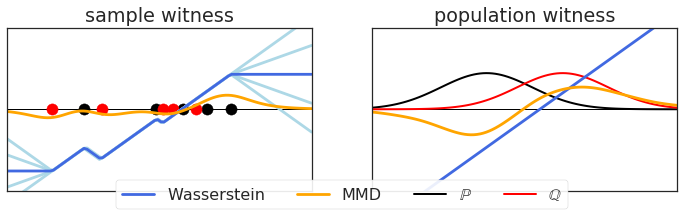

In [5]:
np.random.seed(6)
ns = [5, 70]
Ps = []
Qs = []
for n in ns:
    Ps.append(np.random.normal(loc= .5, scale=.6, size=n))
    Qs.append(np.random.normal(loc=-.5, scale=.6, size=n))

xx = np.linspace(-2, 2, 100)

mmd_wits = [get_MMD_witness(P, Q)(xx) for P, Q in zip(Ps, Qs)]

W_wit_spectra = np.array([
    get_W_witness_spectrum(Ps[0], Qs[0])(xx),
    ((-1 if Ps[1].mean() < Qs[1].mean() else 1) * xx,) * 2,
])
W_wit_spectra -= W_wit_spectra.mean(axis=(1, 2), keepdims=True) + .2




fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 3))

axes[0].axhline(0, color='k', ls='-', lw=1, zorder=-99)
axes[1].axhline(0, color='k', ls='-', lw=1, zorder=-99)

axes[0].scatter(Ps[0], np.zeros(ns[0]), color='black')#, label='$X \sim \mathbb{P}^n$')
axes[0].scatter(Qs[0], np.zeros(ns[0]), color='red'  )#, label='$Y \sim \mathbb{Q}^n$')

axes[1].plot(xx, norm.pdf(xx, loc=-.5, scale=.6), color='black', label='$\mathbb{P}$', lw=2)
axes[1].plot(xx, norm.pdf(xx, loc= .5, scale=.6), color='red'  , label='$\mathbb{Q}$', lw=2)

a, b = W_wit_spectra[0]
for j in range(5):
    r = j / 4.
    if not np.allclose(r, .5):
        axes[0].plot(xx, r * W_wit_spectra[0][0] + (1-r) * W_wit_spectra[0][1], color='lightblue')

axes[0].plot(xx, .5 * W_wit_spectra[0][0] + .5 * W_wit_spectra[0][1], color='royalblue', label='Wasserstein')
axes[0].plot(xx, mmd_wits[0], color='orange', label='MMD')

axes[1].plot(xx, .5 * W_wit_spectra[1][0] + .5 * W_wit_spectra[1][1], color='royalblue', label='Wasserstein')
axes[1].plot(xx, mmd_wits[1], color='orange', label='MMD')

plt.xlim(-2, 2)
plt.ylim(-1.5, 1.5)
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[0].set_title('sample witness')
axes[1].set_title('population witness')

plt.figlegend(loc='lower center', ncol=4, frameon=True, framealpha=.9)
plt.show()

In [7]:
fig.savefig('figs/witness.pdf', bbox_inches='tight', pad_inches=0.01)